This notebook created a 'data' folder into the current directory. Data-wise, I only uploaded the archive.zip folder to save space. To reproduce the results:
1. Unzip the archive.zip folder externally (it must be in the same directory as the 'VER' folder, not in the 'VER' folder itself because it is also used for Identification)
2. Run this notebook

**Importing libraries**:

In [1]:
import os
from scipy.io import wavfile as wav
import shutil
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from IPython.display import Image

Creating a new folder for ID data, "data_ID", copying all files from "50_speakers_audio_data" into it and setting path variable to the new folder:

In [2]:
if not os.path.isdir(os.getcwd() + '\\data'):
    shutil.copytree(str(Path(os.getcwd()).parent.absolute()) + '\\50_speakers_audio_data',
                    os.getcwd() + '\\data')
    
path = os.getcwd() + '\\data\\'
print(path)

c:\Users\Emili\DSIM_project\VER\data\


## **Preliminary track discards**

As done for identification, we will remove the speakers that have track in a different format or at a sampling rate different from 16000

In [3]:
sampling_rates = {}
removed_speakers = []
for speaker in os.listdir(path):
  try:
    sampling_rate, _ = wav.read(path + speaker + '/' + os.listdir(path + speaker)[0])
    if sampling_rate not in sampling_rates.keys():
      sampling_rates[sampling_rate] = [speaker]
    else:
      sampling_rates[sampling_rate].append(speaker)
  except:
    removed_speakers.append(speaker)
    shutil.rmtree(path + speaker)

print('Removed speakers (different format):\n', removed_speakers)
for sampling_rate in sampling_rates.keys():
  print(f"sampling rate {sampling_rate} -> {len(sampling_rates[sampling_rate])} speakers")

Removed speakers (different format):
 ['Speaker0035', 'Speaker0036', 'Speaker0043', 'Speaker0044', 'Speaker0048', 'Speaker0049', 'Speaker_0020']
sampling rate 22050 -> 19 speakers
sampling rate 16000 -> 24 speakers


In [4]:
sampling_rate = 16000

In [5]:
removed_speakers = []
for speaker in os.listdir(path):
    if speaker not in sampling_rates[sampling_rate]:
        shutil.rmtree(path + speaker)
        removed_speakers.append(speaker)
        
print('Removed speakers (different sampling rate):\n', removed_speakers)

Removed speakers (different sampling rate):
 ['Speaker0026', 'Speaker0027', 'Speaker0028', 'Speaker0029', 'Speaker0030', 'Speaker0031', 'Speaker0032', 'Speaker0033', 'Speaker0034', 'Speaker0037', 'Speaker0038', 'Speaker0039', 'Speaker0040', 'Speaker0041', 'Speaker0042', 'Speaker0045', 'Speaker0046', 'Speaker0047', 'Speaker0050']


Let's rename the speaker in a consistent way:

In [6]:
speaker_num = 0
for speaker in os.listdir(path):
  speaker_num = speaker_num + 1
  os.rename(path + speaker, path + f"speaker_{str(speaker_num)}")

We need to select tracks based on the following criteria: having a certain balance between speakers in the train and test sets (explained more in detail later). To do that we need to know the number of tracks for each speaker, so it's better to do the segmentation now to know the actual number of tracks for each speaker.

## **Segmentation**

Text(0.5, 0, 'final 5 sec segment length')

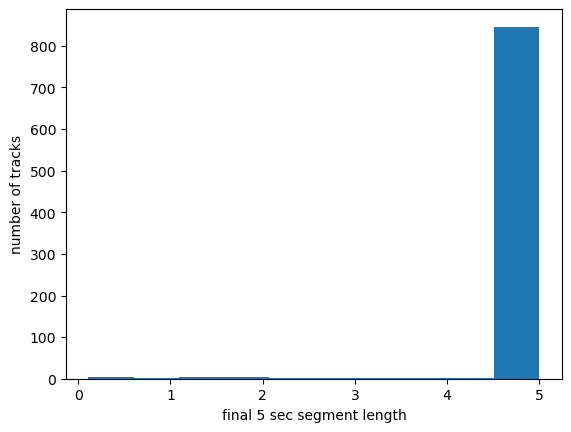

In [7]:
final_segment_lengths_under60 = []
for speaker in os.listdir(path):
  for track in os.listdir(path + speaker):
    _, sound_data = wav.read(path + speaker + '/' + track)
    if sound_data.shape[0]/sampling_rate <= 60: # Won't consider 
      final_segment_lengths_under60.append((sound_data.shape[0]/sampling_rate)%5)
      
plt.hist(final_segment_lengths_under60)
plt.ylabel('number of tracks')
plt.xlabel('final 5 sec segment length')

This time we'll need to discard a few segments that are too short

In [8]:
def feats_temporal(input, size):
    output = np.concatenate((input, np.zeros(size-input.shape[0])))
    return output

In [9]:
for speaker in os.listdir(path):
  track_num = 0
  for track in os.listdir(path + speaker):
    track_num = track_num + 1

    # Getting the 1 minute long track to segment:
    _, sound_data = wav.read(path + speaker + '/' + track)
    
    # Creating the list of 5 sec segments:
    sound_segments = [sound_data[i * sampling_rate: (i+5) * sampling_rate] for i in range(0,60,5)]

    # Discarding empty tracks (in case the track is less than 55 seconds long) and tracks
    # shorter than 4 sec
    sound_segments = [sound_segment for sound_segment in sound_segments
                      if len(sound_segment)>sampling_rate*4]
    
    # Removing the 1 min long track
    os.remove(path + speaker + '/' + track)

    # Converting them to wav files and saving them into the new path
    segment_num = 0
    for sound_segment in sound_segments:
      segment_num = segment_num + 1
      # Adding zeros if shorter than 5 sec
      sound_segment = feats_temporal(input = sound_segment, size = sampling_rate*5)
      # Saving the segment
      wav.write(path + speaker + '/' + f"track{track_num}_segment{segment_num}.wav",
                sampling_rate, sound_segment)

Now that the segmentation is done let's get back to selecting tracks to achieve our balance criteria in the train and test sets:

## **Final track selection**

In [10]:
max_tracks = 0
max_tracks_speaker = ''
min_tracks = float('inf')

for speaker in os.listdir(path):
  
  if len(os.listdir(path + speaker)) < min_tracks:
    min_tracks = len(os.listdir(path + speaker))

  if len(os.listdir(path + speaker)) > max_tracks:
    max_tracks = len(os.listdir(path + speaker))
    max_tracks_speaker = speaker

print('Maximum tracks:', max_tracks)
print('Speaker with maximum tracks:', max_tracks_speaker)
print('Minimum tracks:', min_tracks)

Maximum tracks: 1428
Speaker with maximum tracks: speaker_3
Minimum tracks: 393


Our goal is to create a dataset with only two classes: authorized speaker vs non-authorized speaker.
We want: 
- TRAIN SET: balanced between the two classes (authorized speaker vs non-authorized speaker)
- TEST SET: balanced between the 24 classes (speaker 1 vs speaker 2 vs ... vs speaker 24)

To have as much training data as possible and still mantain the balance between the two classes we will take as the authorized speakerthe speaker with the most tracks.

Assuming we are going to use the train split **α=0.8** and knowing that the user with the most tracks has **1428**, to achieve what we just explained we need to take **335** tracks (rounded down) for each of the other 23 speakers (achievable becuase the other speakers have at least 393 tracks).

Belown our calculation to get to these numbers are shown:

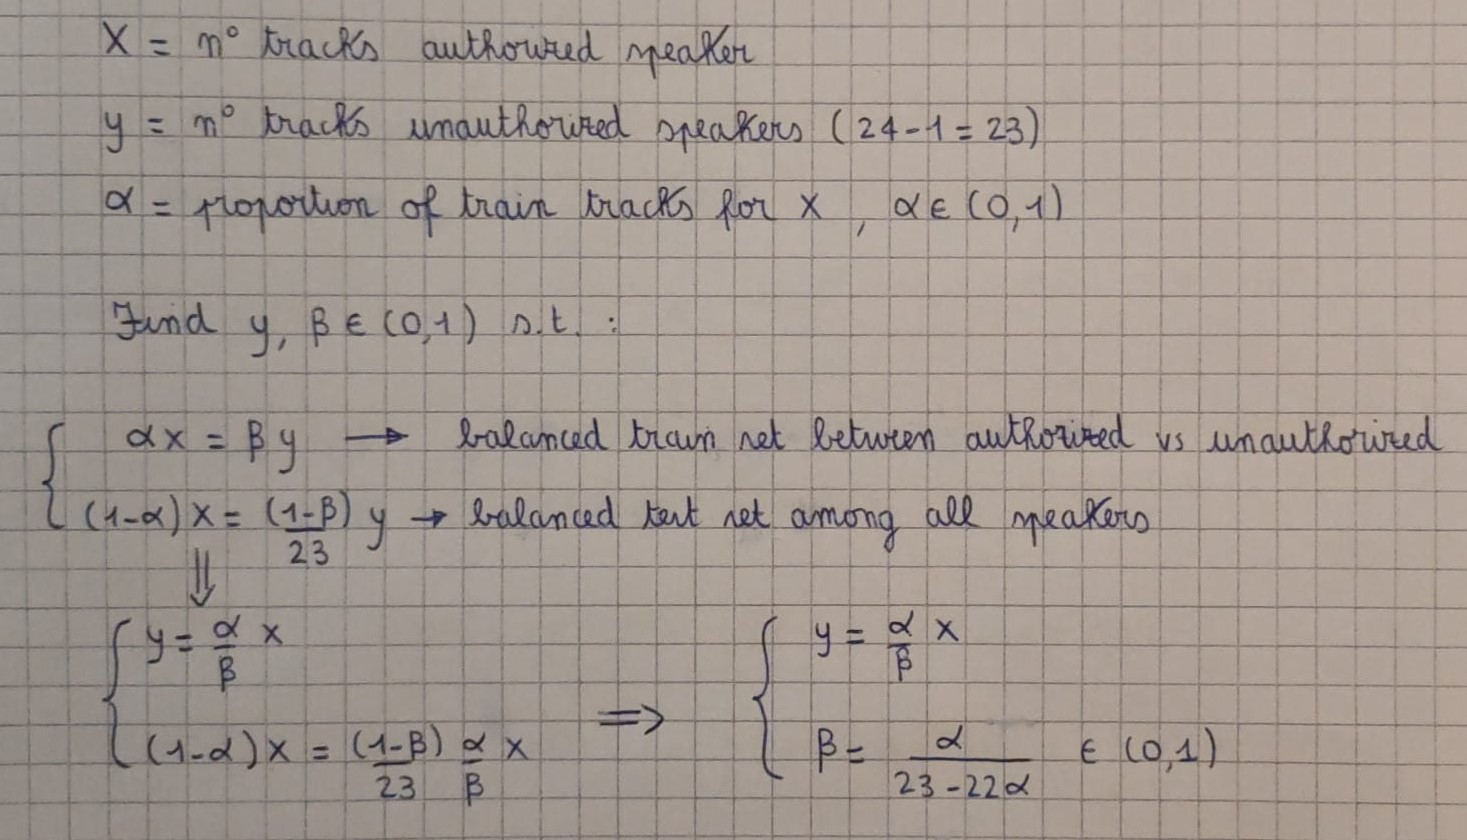

In [39]:
Image(os.getcwd() + '\\verification_split.jpg')

Let's implement this selection:

In [11]:
removed_tracks = []
for speaker in os.listdir(path):
    if speaker == max_tracks_speaker:
        continue
    
    track_num = 0
    for track in os.listdir(path + speaker):
        track_num = track_num + 1    
        if track_num > 335:
            os.remove(path + speaker + '/' + track)
            removed_tracks.append(track)

print(f'{len(removed_tracks)} tracks removed:')

8978 tracks removed:


Finally let's check that the balanced we wanted is achieved also seconds-wise:

In [12]:
duration_dict = {}
for speaker in os.listdir(path):
  audio_seconds = 0
  for track in os.listdir(path + speaker):
    _, sound_data = wav.read(path + speaker + '/' + track)
    audio_seconds = audio_seconds + sound_data.shape[0]/sampling_rate
  duration_dict[speaker] = audio_seconds
  
print(duration_dict)

{'speaker_1': 1675.0, 'speaker_10': 1675.0, 'speaker_11': 1675.0, 'speaker_12': 1675.0, 'speaker_13': 1675.0, 'speaker_14': 1675.0, 'speaker_15': 1675.0, 'speaker_16': 1675.0, 'speaker_17': 1675.0, 'speaker_18': 1675.0, 'speaker_19': 1675.0, 'speaker_2': 1675.0, 'speaker_20': 1675.0, 'speaker_21': 1675.0, 'speaker_22': 1675.0, 'speaker_23': 1675.0, 'speaker_24': 1675.0, 'speaker_3': 7140.0, 'speaker_4': 1675.0, 'speaker_5': 1675.0, 'speaker_6': 1675.0, 'speaker_7': 1675.0, 'speaker_8': 1675.0, 'speaker_9': 1675.0}


Every non authorized speaker has the same amount of seconds of data and the authorized speaker/unauthorized speaker ratio is 4.26, which is exactly the 1428/3354we wanted (all segments are exactly 5 seconds, the few segments between 4 and 5 seconds were discarded in the selection process).

In [13]:
if not os.path.isdir(os.getcwd() + '\\data\\auth_speaker'):
    os.mkdir(os.getcwd() + '\\data\\auth_speaker')
    
if  not os.path.isdir(os.getcwd() + '\\data\\unauth_speakers'):
    os.mkdir(os.getcwd() + '\\data\\unauth_speakers')

In [14]:
for speaker in os.listdir(path):
  
  if speaker == max_tracks_speaker:
    for track in os.listdir(path + speaker):
      shutil.move(path + speaker + '/' + track, os.getcwd() + '\\data\\auth_speaker')
    os.rmdir(path + speaker)
    
  elif speaker != 'auth_speaker':
    shutil.move(path + speaker, os.getcwd() + '\\data\\unauth_speakers')